# Model Interpretability
* A machine learning algorithm’s interpretability refers to how easy it is for humans to understand the processes it uses to arrive at its outcomes.
* When using an algorithm’s outcomes to make high-stakes decisions, it’s important to know which features the model did and did not take into account.
* If a model isn’t highly interpretable, the business might not be legally permitted to use its insights to make changes to processes.

### SHAP

* Recently the use of Shapley values has had a major resurgence in machine learning, particularly in the field model interpretability. Recent work has created the SHAP python and R libraries. 
* SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. SHAP is based on the game theoretically optimal Shapley values (Shapley, 1953). The approach connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.
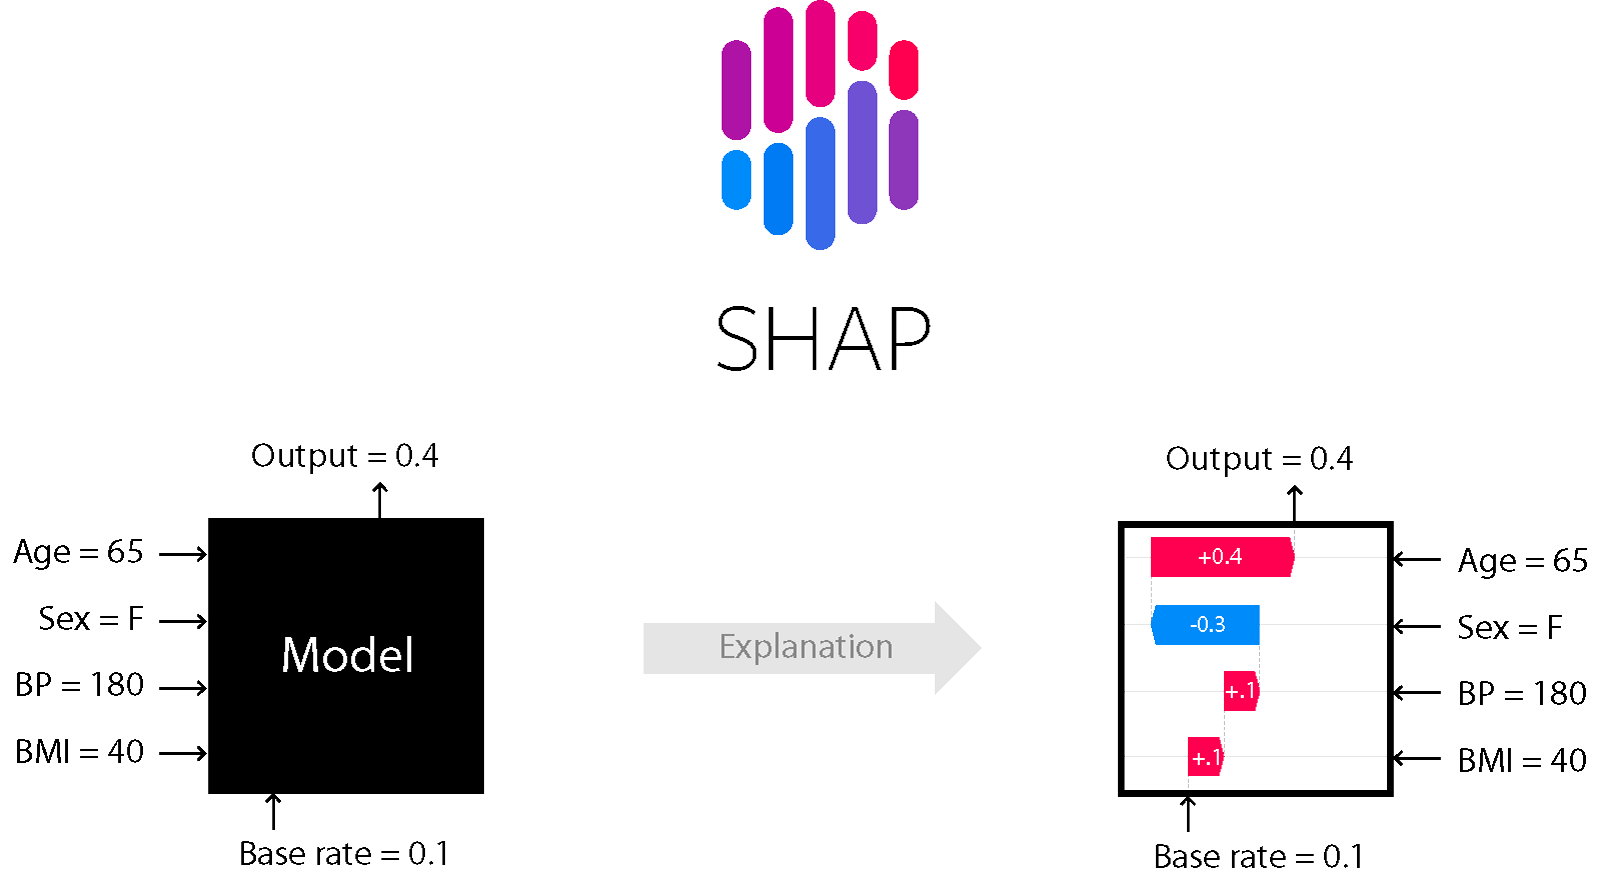

In [ ]:
#Installing SHAP and other required libraries
!pip install shap
!pip install numpy==1.20

In [ ]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
# import math 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick # For specifying the axes tick format 
from scipy.stats import norm, skew #for some statistics
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#Reading Data
telecom_cust = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')  

In [ ]:
#Reading Data
telecom_cust = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv') 

# Exploratory Data Analysis

### Dataset - Telco customer Churn
Each row represents a customer; each column contains the following customer’s attributes:
* **customerID** : Customer ID
* **gender** : Whether the customer is a male or a female
* **SeniorCitizen** : Whether the customer is a senior citizen or not (1, 0)
* **Partner** : Whether the customer has a partner or not (Yes, No)
* **Dependents** : Whether the customer has dependents or not (Yes, No)
* **tenure** : Number of months the customer has stayed with the company
* **PhoneService** : Whether the customer has a phone service or not (Yes, No)
* **MultipleLines** : Whether the customer has multiple lines or not (Yes, No, No phone service)
* **InternetService** : Customer’s internet service provider (DSL, Fiber optic, No)
* **OnlineSecurity** : Whether the customer has online security or not (Yes, No, No internet service)
* **OnlineBackup** : Whether the customer has online backup or not (Yes, No, No internet service)
* **DeviceProtection** : Whether the customer has device protection or not (Yes, No, No internet service)
* **TechSupport** : Whether the customer has tech support or not (Yes, No, No internet service)
* **StreamingTV** : Whether the customer has streaming TV or not (Yes, No, No internet service)
* **StreamingMovies** : Whether the customer has streaming movies or not (Yes, No, No internet service)
* **Contract** : The contract term of the customer (Month-to-month, One year, Two year)
* **PaperlessBilling** : Whether the customer has paperless billing or not (Yes, No)
* **PaymentMethod** : The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* **MonthlyCharges** : The amount charged to the customer monthly
* **TotalCharges** : The total amount charged to the customer
* **Churn(Target)** : Whether the customer churned or not (Yes or No)

### Problem Statement
**Binary Classification**: Predict is the customer is going to leave.  i.e. Yes or No.

* Complete EDA & Modeling using LGBM Link - https://www.kaggle.com/chakrabortyarnab/telco-churn-eda-optuna-tuned-lgbm-f1-85
* AutoML - Model Evaluationa and Comparison using PyCaret Link - https://www.kaggle.com/code/chakrabortyarnab/pycaret-classification-using-automl

In [ ]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Sample Value'] = df.loc[0].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2)
    return summary
resumetable(telecom_cust)

**Entropy** is defined as the randomness or measuring the disorder of the information being processed.

**Actions required for data preparation:**

* Converting Total Charges to a numerical data type.
* Removing customer IDs from the data set as it is unique to every record and we therefore won't use it as a predictor variable.
* Encoding categorical features.

In [ ]:
#Dropping customer ID
cust = telecom_cust.iloc[:,1:].copy()

#Label Encoding
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
cust['Partner'] = le.fit_transform(cust.Partner.values)
cust['Dependents'] = le.fit_transform(cust.Dependents.values)
cust['gender'] = le.fit_transform(cust.gender.values)
cust['PhoneService'] = le.fit_transform(cust.PhoneService.values)
cust['PaperlessBilling'] = le.fit_transform(cust.PaperlessBilling.values)
cust['Churn'] = le.fit_transform(cust.Churn.values)


#Coverting totalCharges to numerical data type.
cust.TotalCharges = pd.to_numeric(cust.TotalCharges, errors='coerce')

**Action :**
Checking for missing values after changing the data type.

### Handling Missing Values

In [ ]:
cust.TotalCharges.isna().sum()

In [ ]:
cust[cust.TotalCharges.isna()][['tenure','MonthlyCharges','TotalCharges','Churn']]

**Observation**: All the new customers(i.e. tenure=0 months) have no total charges data available.

**Action**: We would drop these rows here as all of them have been in the system for less than a month and Customers are marked as churned if they have left the system in the last one month.

In [ ]:
#Removing missing values
cust.dropna(inplace = True)

### Churn Rate

In [ ]:
print("Customer Churn Rate(%):")
print(round(cust['Churn'].value_counts(normalize=True) * 100,2))

### Identifying correlation of Predictor Variables with Target label Churn

In [ ]:
# Convert all Categorical variables into dummy variables
cust_dummies=pd.get_dummies(cust)

In [ ]:
# Correlation plot with Churn
plt.figure(figsize=(15,5))
cust_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

**Observation**:

* Month to month contracts, absence of online security and tech support seem to be positively correlated with churn.
* Tenure, two year contracts seem to be negatively correlated with churn.
* Interestingly, services such as Online security, Online backup, Tech support and others without internet connection seem to be negatively related to churn.

### Visualizing against Churn

In [ ]:
def kdeplot(feature):
    plt.figure(figsize=(10, 3))
    plt.title("Distribution for {}".format(feature))
    ax0 = sns.kdeplot(cust[cust['Churn'] == 0][feature].dropna(), color= 'grey', label= 'Churn: No')
    ax1 = sns.kdeplot(cust[cust['Churn'] == 1][feature].dropna(), color= 'Red', label= 'Churn: Yes')
    ax0.legend(["Not Churn","Churn"],loc='upper right')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

**Observation**:
* Churn by Tenure: Recent clients are more likely to churn.
* Churn by Monthly Charges: Clients with higher MonthlyCharges are more likely to churn.
* Churn by Total Charges: It seems that there is higer churn when the total charges are lower.

### Train Test Split for Modeling

In [ ]:
#Setting the target label and predictor variables
y = cust_dummies.Churn.values
X = cust_dummies.drop(columns='Churn')

# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Modeling using Light GBM
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

**SHAP is Model Agnostic**

In [ ]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

In [ ]:
# predict the results
y_pred=clf.predict(X_test)

In [ ]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

## Model Evaluation
Let's understand what is meant by Precision and Recall.
* **Precision** measures the percentage of customers predicted by us to Churn that were correctly classified.
* **Recall** measures the percentage of actual customers that churned were correctly classified.

When we predict that the customers will churn, **62%** of customers actually churned. Whereas, out of all the customers that churned we were able to capture **51**% of all them correctly.

We can further tune our models to be more precise or have a better recall based on the business requirement.

### Feature importance
Feature (variable) importance indicates how much each feature contributes to the model prediction. Basically, it determines the degree of usefulness of a specific variable for a current model and prediction.

In [ ]:
#Feature Importance
lgb.plot_importance(clf,figsize=(10, 9))

**Observation:**

Similar to our EDA, we can see that Monthly charges, Total charges and tenure are significant in predicting whether a customer would churn or not. 

However, to understand how a particular feature impacts the model prediction, we will perform SHAP Analysis

# SHAP Analysis

In [ ]:
import shap

In [ ]:
# 100 instances for use as the background distribution
X100 = shap.utils.sample(X, 100) 

### Interpret Light GBM Regression Model using SHAP

In [ ]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(clf.predict, X100)
shap_values = explainer(X_train)

### Beeswarm plot 
* For each variable, every instance of the dataset appears as it's own point, the points are distributed across the x-axis according to their SHAP values.
* The input variables are ranked from the top in accordance to their mean SHAP values.

In [ ]:
shap.plots.beeswarm(shap_values)

**Observation:** 
* Here we can observe that Tenure is the most important feature followed by Monthly Contracts.
* However, other features, like PaymentMethod_Electronic check can have more impact on a particular individual.

### Bar Plot
Displaying the average SHAP values of each individual feature.


In [ ]:
shap.plots.bar(shap_values)

**Observation:**
* Here we see that tenure of the Customer is the most influential variable, contributing on average 0.1 to predict Churn Customers.

### Scatter plot
Let's observe the distribution of SHAP values for the most significant feature tenure

In [ ]:
shap.plots.scatter(shap_values[:,"tenure"])

### Partial Dependency Plot

In [ ]:
shap.partial_dependence_plot(
    "tenure", clf.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

**Observation:**
* A decrease on the expected value of a Customer Churning is observed as the tenure .
* If the customer completes more than 2 years(24 months), they are highly unlikely to churn.


# The additive nature of Shapley values

### Waterfall Plot
For machine learning models, the SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained. 

In [ ]:
#Example 1
shap.plots.waterfall(shap_values[1], max_display=10)

Here, the baseline value is 0.17 and the predicted value is 1(i.e. the Customer will churn)

The difference in the predicted value and the baseline value is explained by the following predictors:
* The customer has been there for a **tenure of 3 months** which increases the baseline value by 0.26 
* **Total Charges of 188.7 usd** pending increases by 0.21.
* The customer has opted for **Monthly Contracts** which also increases by 0.16.
* Having **No Online Security and Tech Support** increases by 0.11 and 0.08 respectively.
* Having no Fiber optic Internet service decreases by 0.04.

In [ ]:
#Example 2
shap.plots.waterfall(shap_values[20], max_display=10)

Here, the baseline value is 0.17 and the predicted value is 1(i.e. the Customer will churn)

The difference in the predicted value and the baseline value is explained by the following predictors:
* Having **Tech Support and Online Security** decreases the the baseline value by 0.12 and 0.05 respectively
* The customer has been there for a **tenure of 2 months** which increases by 0.15
* **Total Charges of 31.2 usd** pending increases by 0.02.
* By not having Internet Service set as Fiber optic, reduces by 0.11.
* The customer has opted for **Monthly Contracts** which also increases by 0.04.
* Having a low **Monthly Charge of 19.65** decreases by 0.05.

# Summary
* We performed EDA on the Telco Customer Churn dataset.
* We used Light GBM model to predict the Churn Customers.
* Then we performed SHAP Analysis to determine the impact of each individual predictor variable used by the Light GBM model to predict the Churn Customers.

#### If you found this notebook helpful or you just liked it , some **upvotes** would be very much appreciated

# License

**References**
* https://lightgbm.readthedocs.io/en/v3.3.2/
* https://shap.readthedocs.io/en/latest/

Copyright (c) 2022 chakraborty-arnab

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.